# Example of discrete and inverse discrete Fourier transform

In [1]:
import numpy as np
import numpy.testing as npt
import xarray as xr
import xrft
import numpy.fft as npft
import scipy.signal as signal
import dask.array as dsar
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we provide examples of the discrete Fourier transform (DFT) and its inverse, and how `xrft` automatically harnesses the metadata. We compare the results to conventional `numpy.fft` to highlight the strengths of `xrft`.

## A case with synthetic data

### Generate synthetic data centered around zero

In [21]:
k0 = 1/0.52
T = 4.
dx = 0.02
x = np.arange(-2*T,2*T,dx) 
y = np.cos(2*np.pi*k0*x) 
y[np.abs(x)>T/2]=0.
da = xr.DataArray(y, dims=('x',), coords={'x':x})

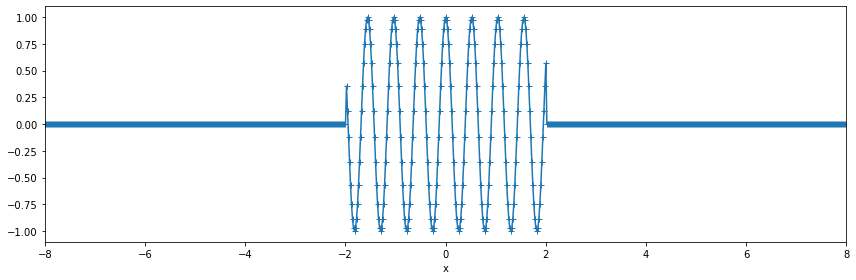

In [22]:
fig, ax = plt.subplots(figsize=(12,4)) 
fig.set_tight_layout(True)
da.plot(ax=ax, marker='+', label='original signal') 
ax.set_xlim([-8,8]);

**Let's take the Fourier transform**

We will compare the Fourier transform with and without taking into consideration about the phase information.

In [23]:
da_dft = xrft.dft(da, true_phase=True, true_amplitude=True) # Fourier Transform w/ consideration of phase
da_fft = xrft.fft(da)                                       # Fourier Transform w/ numpy.fft-like behavior
da_npft = npft.fft(da)

In [24]:
k = da_dft.freq_x # wavenumber axis
TF_s = T/2*(np.sinc(T*(k-k0)) + np.sinc(T*(k+k0))) # Theoretical result of the Fourier transform

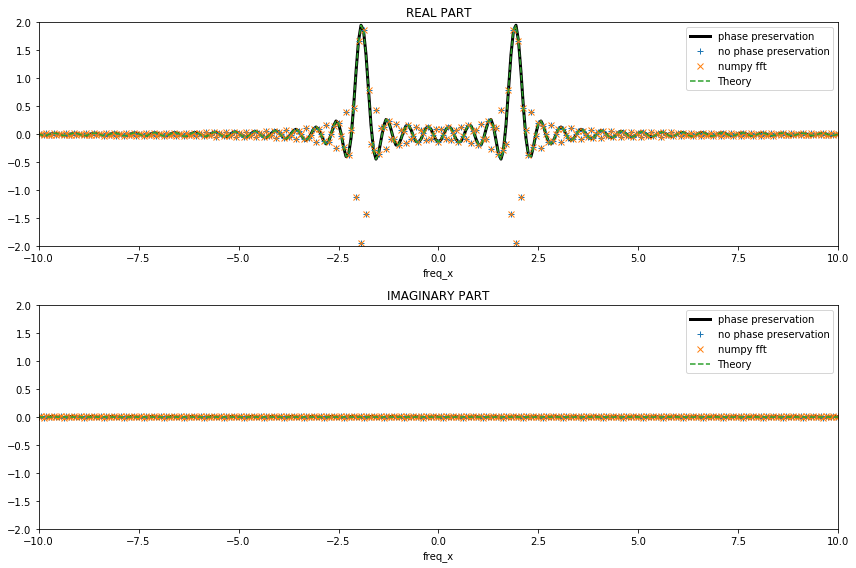

In [26]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(da_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
((da_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation') 
ax1.plot(k, (npft.fftshift(da_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(k, TF_s.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2,2])
ax1.legend()
ax1.set_title('REAL PART')

(da_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
((da_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(k, (npft.fftshift(da_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(k, TF_s.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2,2])
ax2.legend()
ax2.set_title('IMAGINARY PART');

`xrft.dft`, `xrft.fft` (and `numpy.fft`) all give the same amplitudes as theory (as the coordinates of the original data was centered) but the latter two get the sign wrong due to losing the phase information.

**Perform the inverse transform**

In [27]:
ida_dft = xrft.idft(da_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
ida_fft = xrft.ifft(da_fft)

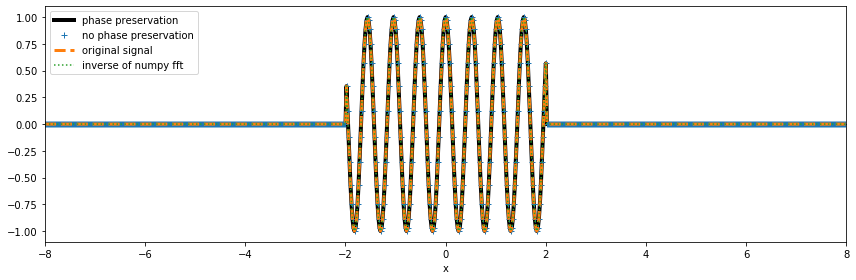

In [28]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
ida_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x, ida_fft.real, linestyle='', marker='+', label='no phase preservation') # w/out the phase information, the coordinates are lost
da.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x, npft.ifft(da_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([-8,8])
ax.legend(loc='upper left');

### Synthetic data not centered around zero

**Now let's shift the coordinates so that they are not centered.**

**This is where the `xrft` magic happens.** With the relevant flags, `xrft`'s dft can preserve information about the data's location in its original space. This information is not preserved in a `numpy` fourier transform. This section demonstrates how to preserve this information using the `true_phase=True`, `true_amplitude=True` flags.

In [31]:
nshift = 70                          # defining a shift
x0 = dx*nshift 
nda = da.shift(x=nshift).dropna('x')

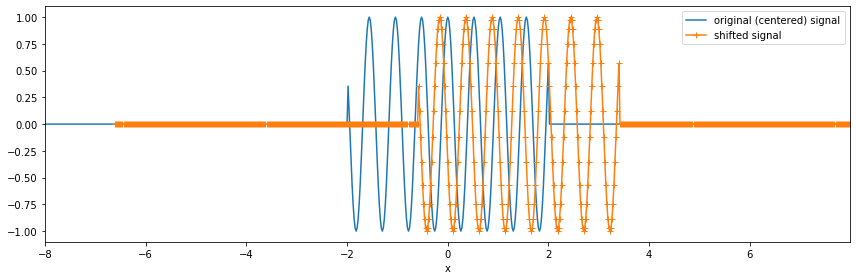

In [32]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
da.plot(ax=ax, label='original (centered) signal') 
nda.plot(ax=ax, marker='+', label='shifted signal') 
ax.set_xlim([-8,nda.x.max()])
ax.legend();

**We consider again the Fourier transform.**

In [33]:
nda_dft = xrft.dft(nda, true_phase=True, true_amplitude=True) # Fourier Transform w/ phase preservation 
nda_fft = xrft.fft(nda)                                       # Fourier Transform w/out phase preservation
nda_npft = npft.fft(nda)

In [34]:
nk = nda_dft.freq_x # wavenumber axis
TF_ns = T/2*(np.sinc(T*(nk-k0)) + np.sinc(T*(nk+k0)))*np.exp(-2j*np.pi*nk*x0) # Theoretical FT (Note the additional phase)

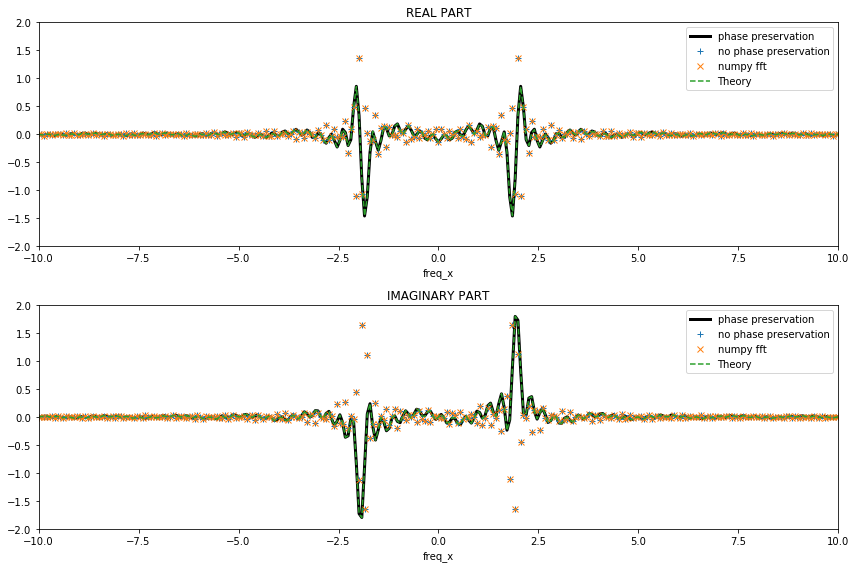

In [35]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,8), nrows=2, ncols=1)
fig.set_tight_layout(True)

(nda_dft.real).plot(ax=ax1, linestyle='-', lw=3, c='k', label='phase preservation') 
((nda_fft*dx).real).plot(ax=ax1, linestyle='', marker='+',label='no phase preservation')
ax1.plot(nk, (npft.fftshift(nda_npft)*dx).real, linestyle='', marker='x',label='numpy fft')
ax1.plot(nk, TF_ns.real, linestyle='--', label='Theory')
ax1.set_xlim([-10,10])
ax1.set_ylim([-2.,2])
ax1.legend()
ax1.set_title('REAL PART')

(nda_dft.imag).plot(ax=ax2, linestyle='-', lw=3, c='k', label='phase preservation') 
((nda_fft*dx).imag).plot(ax=ax2, linestyle='', marker='+', label='no phase preservation') 
ax2.plot(nk, (npft.fftshift(nda_npft)*dx).imag, linestyle='', marker='x',label='numpy fft')
ax2.plot(nk, TF_ns.imag, linestyle='--', label='Theory')
ax2.set_xlim([-10,10])
ax2.set_ylim([-2.,2.])
ax2.legend()
ax2.set_title('IMAGINARY PART');

The expected additional phase (i.e. the imaginary part; $e^{-i2\pi kx_0}$) that appears in theory is retrieved with `xrft.dft` but not with `xrft.fft` nor `numpy.fft`. This is because in `numpy.fft`, the input data is expected to be centered around zero. **In the current version of `xrft`, the behavior of `xrft.dft` defaults to `xrft.fft` so set the flags `true_phase=True` and `true_amplitude=True` in order to have the results matching with theory.**

**Now, let's take the inverse transform.**

In [36]:
inda_dft = xrft.idft(nda_dft, true_phase=True, true_amplitude=True) # Signal in direct space 
inda_fft = xrft.ifft(nda_fft)

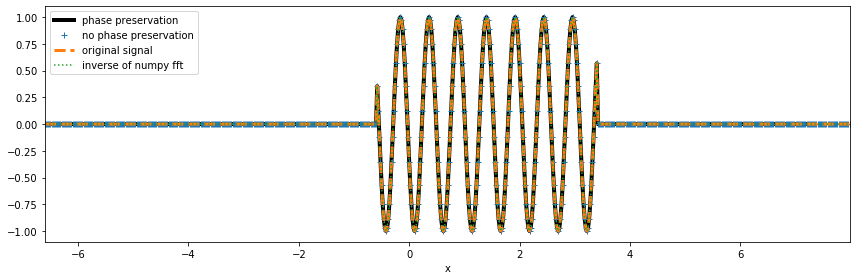

In [37]:
fig, ax = plt.subplots(figsize=(12,4))
fig.set_tight_layout(True)
inda_dft.real.plot(ax=ax, linestyle='-', c='k', lw=4, label='phase preservation')
ax.plot(x[nshift:], inda_fft.real, linestyle='', marker='+', label='no phase preservation')
nda.plot(ax=ax, ls='--', lw=3, label='original signal')
ax.plot(x[nshift:], npft.ifft(nda_npft).real, ls=':', label='inverse of numpy fft')
ax.set_xlim([nda.x.min(),nda.x.max()])
ax.legend(loc='upper left');

Note that we are only able to match the inverse transforms of `xrft.ifft` and `numpy.ifft` to the data `nda` to it being Fourier transformed because we "know" the original data `da` was shifted by `nshift` datapoints as we see in `x[nshift:]`. **Using `xrft.idft` along with `xrft.dft` with the flags `true_phase=True` and `true_amplitude=True` automatically takes care of the information of shifted coordinates.**

## A case with real data

Load atmosheric temperature from the NMC reanalysis.

In [4]:
da = xr.tutorial.open_dataset("air_temperature").air
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
[3869000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [6]:
Fda = xrft.dft(da.isel(time=0), dim="lat", true_phase=True, true_amplitude=True)
Fda

<xarray.DataArray (freq_lat: 25, lon: 53)>
array([[ 55.72721061-46.86182115j,  54.88410513-45.81648436j,
         54.44861105-45.4792758j , ...,  63.78368643-52.78354988j,
         60.99712143-50.28091047j,  57.94756055-48.51852927j],
       [-38.90906614-66.9663849j , -38.90038095-67.92497252j,
        -38.544492  -68.17925905j, ..., -41.94737401-74.09175983j,
        -40.00936528-70.47655747j, -39.05651073-68.04032158j],
       [-77.82019891+12.50876021j, -79.02288653+10.06164636j,
        -80.34175059 +9.81548668j, ..., -86.83039434+26.4819109j ,
        -84.02694401+23.31755583j, -81.26451369+21.4268003j ],
       ...,
       [-77.82019891-12.50876021j, -79.02288653-10.06164636j,
        -80.34175059 -9.81548668j, ..., -86.83039434-26.4819109j ,
        -84.02694401-23.31755583j, -81.26451369-21.4268003j ],
       [-38.90906614+66.9663849j , -38.90038095+67.92497252j,
        -38.544492  +68.17925905j, ..., -41.94737401+74.09175983j,
        -40.00936528+70.47655747j, -39.05651073+68.04032158j],
       [ 55.72721061+46.86182115j,  54.88410513+45.81648436j,
         54.44861105+45.4792758j , ...,  63.78368643+52.78354988j,
         60.99712143+50.28091047j,  57.94756055+48.51852927j]])
Coordinates:
  * lon       (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time      datetime64[ns] 2013-01-01
  * freq_lat  (freq_lat) float64 -0.192 -0.176 -0.16 -0.144 ... 0.16 0.176 0.192

The coordinate metadata is lost during the DFT operation so we need to specify the `lag` to retrieve the latitudes back in the inverse transform. The original latitudes are centered around 45$^\circ$ so we set the lag to `lag=45`.

In [8]:
Fda_1 = xrft.idft(Fda, dim="freq_lat", true_phase=True, true_amplitude=True, lag=45)
Fda_1

<xarray.DataArray (lat: 25, lon: 53)>
array([[296.29000854-7.01488818e-16j, 296.79000854-2.41028295e-15j,
        297.1000061 -1.08051561e-15j, ..., 296.8999939 +2.07870428e-15j,
        296.79000854+1.39068454e-15j, 296.6000061 +1.98243140e-15j],
       [295.8999939 -1.36617001e-16j, 296.19998169-3.08854147e-15j,
        296.79000854-2.27797690e-16j, ..., 295.8999939 -2.06120304e-15j,
        295.8999939 -7.63307736e-16j, 295.19998169+2.90958929e-15j],
       [296.6000061 +2.18513309e-15j, 296.19998169-5.34587573e-16j,
        296.3999939 -1.70159409e-15j, ..., 295.3999939 -9.67078004e-16j,
        295.1000061 -2.97325892e-15j, 294.69998169+2.84108954e-15j],
       ...,
       [250.        +1.32015223e-15j, 249.79998779+5.34587573e-16j,
        248.88999939-1.80369123e-15j, ..., 233.19999695+9.67078004e-16j,
        236.38999939+3.00722368e-17j, 241.69999695+3.04528382e-15j],
       [243.79998779-1.32169378e-16j, 244.5       -4.76080394e-15j,
        244.69999695-1.17678849e-15j, ..., 232.79998779+1.86297913e-15j,
        235.29998779-3.02882224e-16j, 239.29998779-9.67078004e-16j],
       [241.19999695+5.26510200e-16j, 242.5       -1.34198513e-15j,
        243.5       -3.83146461e-16j, ..., 232.79998779+2.46618241e-15j,
        235.5       +3.62856196e-16j, 238.59999084+4.17030299e-16j]])
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
  * lat      (lat) float64 15.0 17.5 20.0 22.5 25.0 ... 65.0 67.5 70.0 72.5 75.0

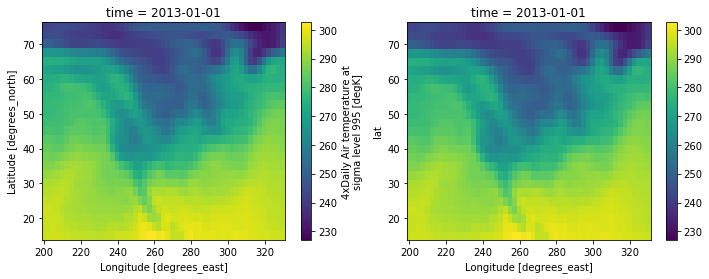

In [20]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,4), nrows=1, ncols=2)
da.isel(time=0).plot(ax=ax1)
Fda_1.real.plot(ax=ax2)

We see the inverse DFT of the Fourier transformed original temperature data returns the original data.